# Design Single Country Nat Cat Bonds

In [1]:
#import generald packages
import numpy as np

#import climada stuff
from climada.hazard import tc_tracks, Centroids, TropCyclone
from climada.entity import LitPop
from climada.util.api_client import Client
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.engine import ImpactCalc
import functions as fct
import exposures as ex


client = Client()

c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


### Load TC Tracks

In [2]:
basins = ['EP','NA','NI','SI','SP','WP']

storms_basin = fct.init_STORM_tracks(basins=basins, load_haz=True)

----------------------Initiating Hazard----------------------
----------------------Initiating Hazard----------------------
----------------------Initiating Hazard----------------------
----------------------Initiating Hazard----------------------
----------------------Initiating Hazard----------------------
----------------------Initiating Hazard----------------------


### Generate Exposure Data 
Generate exposure data using newest available data by myself. Can choose fin_mode myself, reference year, and resolution. 


----------------------Loading Exposure----------------------
----------------------Generating Centroids----------------------
----------------------Define STORM Basins----------------------
STORM basin of country:  ['SI']


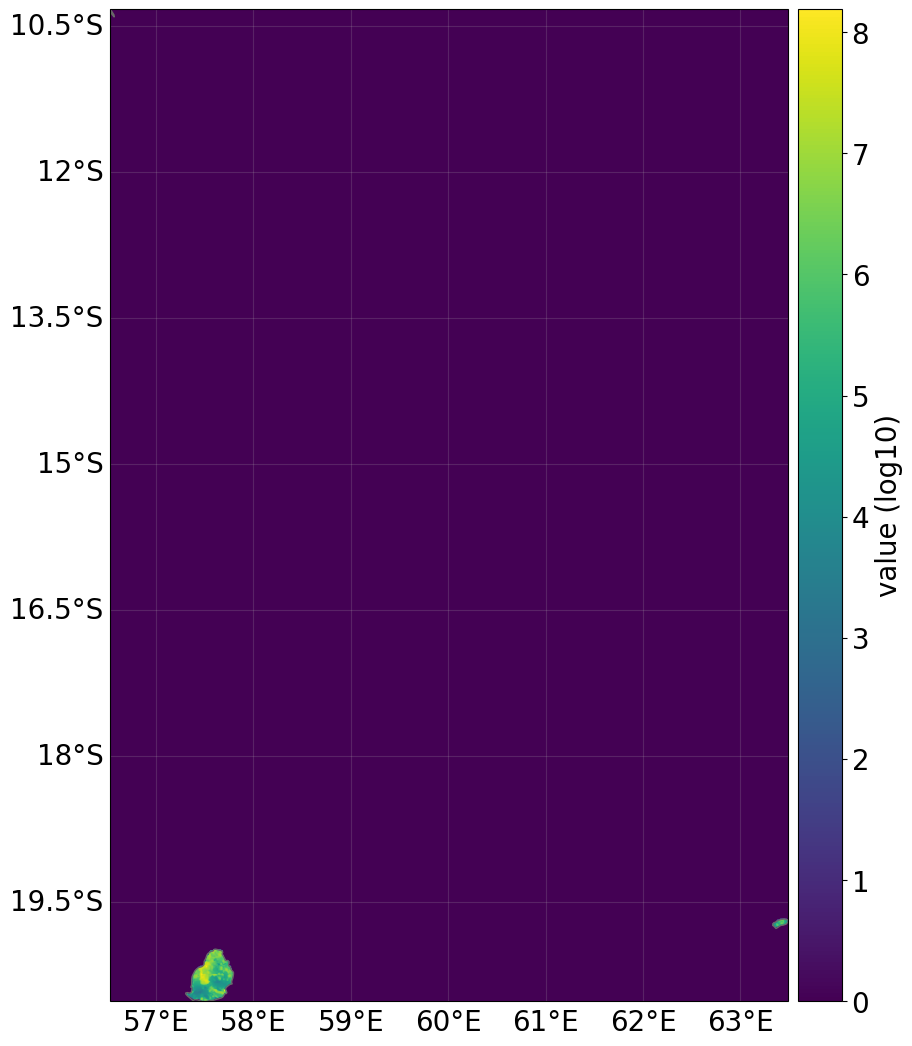

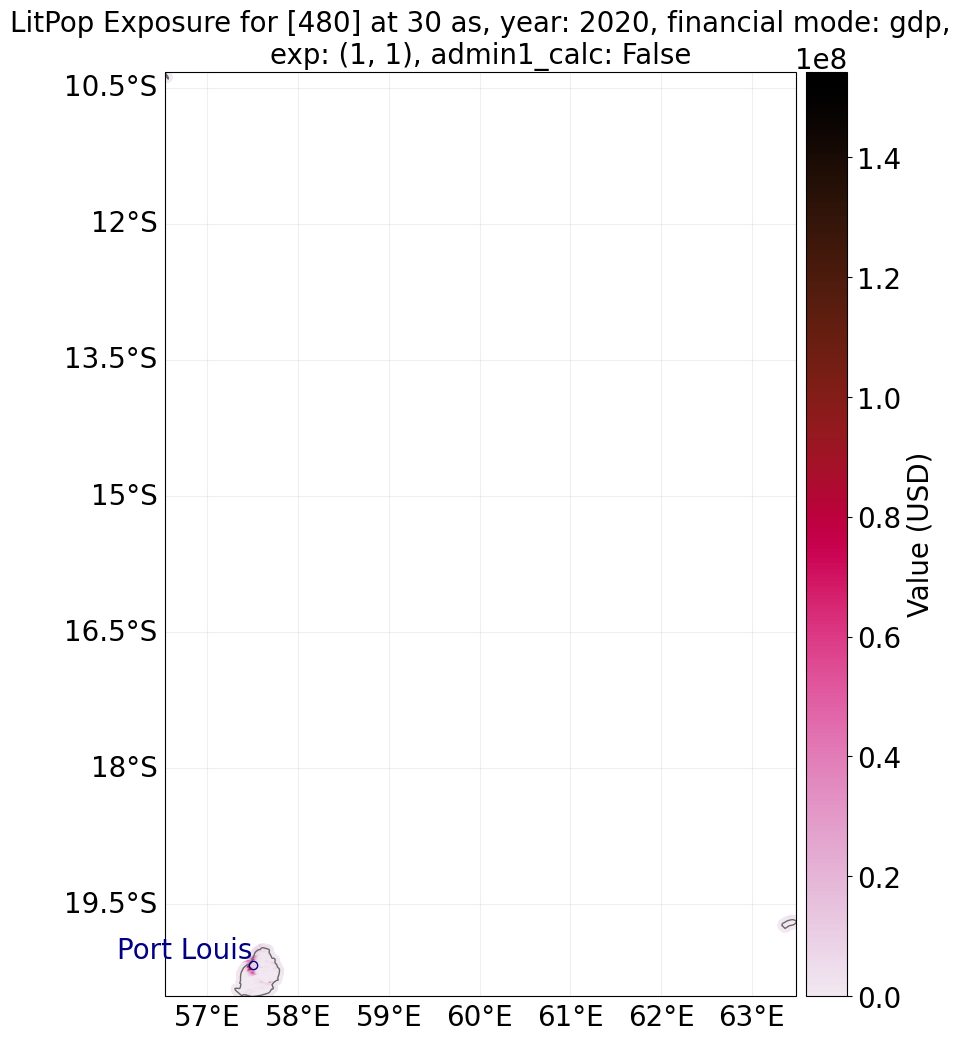

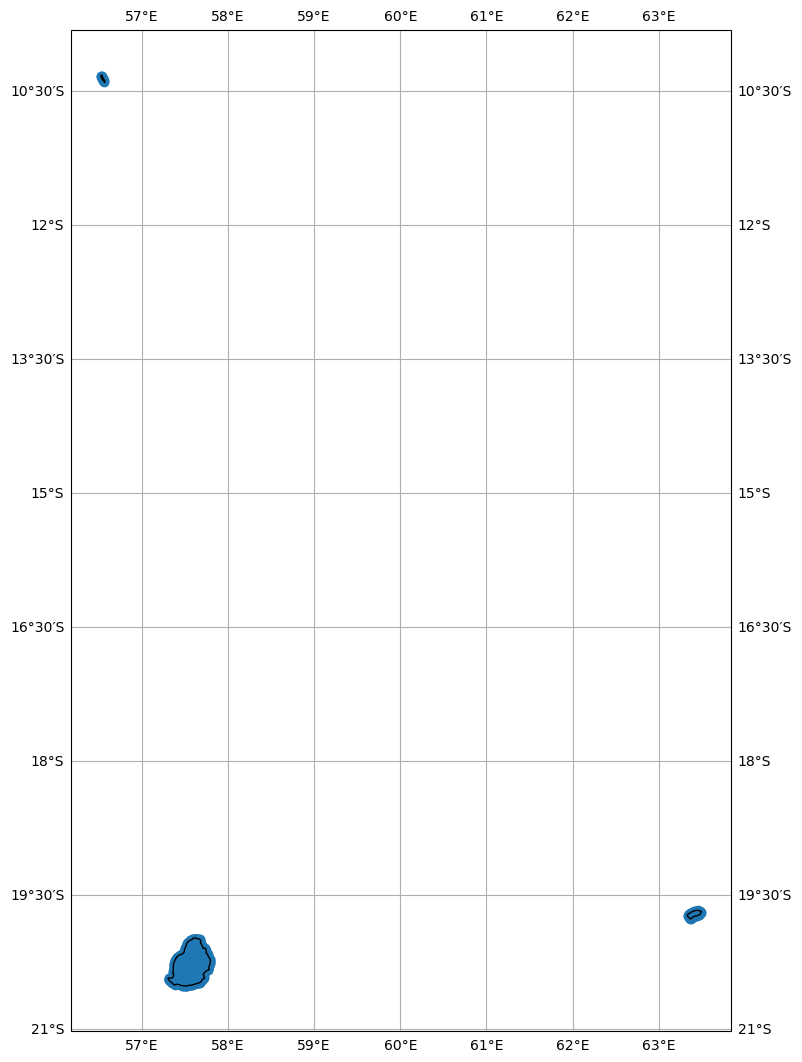

In [3]:
#Generate exposure data
country = 480

exp, centrs, applicable_basins, storm_basin_sub = ex.generate_exposure(country, storms_basin, load_exp=True)

ax_sub = storm_basin_sub[applicable_basins[0]].plot()
ax_sub.get_legend()._loc = 2

### Generate TC Class

c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:308: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_buffer = exposure.gdf.buffer(distance=buffer, resolution=0)
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\shapely\constructive.py:181: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry colu

Number of tracks in SI basin: 14282


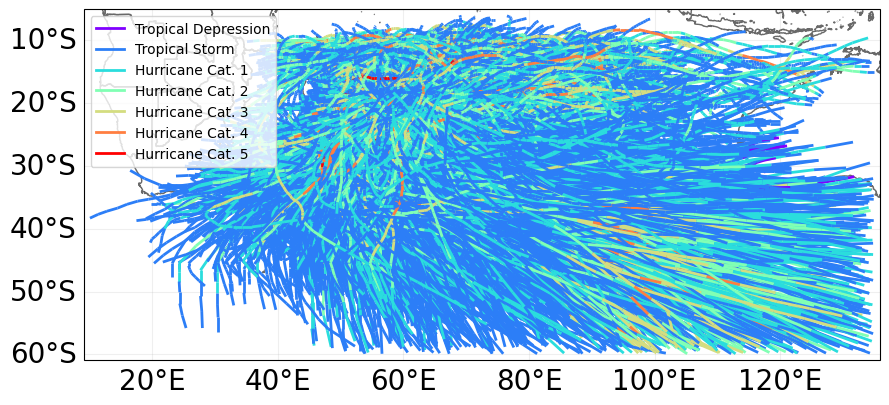

In [4]:
#filter tc tracks of applicalble basin which are located close to exposure values
buffer = 1.0

storm_basin_sub = fct.filter_tc_tracks(storms_basin, applicable_basins, exp, buffer)

ax_sub = storm_basin_sub[applicable_basins[0]].plot()
ax_sub.get_legend()._loc = 2

In [ ]:
#define frequency correction factor for STORM dataset
freq_corr_STORM = 1/1000
#generate tc class
tc_storms = fct.init_tc_hazard(storm_basin_sub, basins, freq_corr_STORM)

### Calculate Impact

In [ ]:
#import regional calibrated impact function for TC
# prepare impact calcuation - after Samuel Eberenz
# The iso3n codes need to be consistent with the column “region_id” in the 
# 1. Init impact functions:
impact_func_set = trop_cyclone.ImpfSetTropCyclone()
impf_set = impact_func_set.from_calibrated_regional_ImpfSet()
impf_set.check()

# get mapping: country ISO3n per region:
iso3n_per_region = impf_id_per_region = impact_func_set.get_countries_per_region()[2]
    
code_regions = {'NA1': 1, 'NA2': 2, 'NI': 3, 'OC': 4, 'SI': 5, 'WP1': 6, \
                'WP2': 7, 'WP3': 8, 'WP4': 9, 'ROW': 10}

# match exposure with correspoding impact function
for calibration_region in impf_id_per_region:
    for country_iso3n in iso3n_per_region[calibration_region]:
        exp.gdf.loc[exp.gdf.region_id== country_iso3n, 'if_TC'] = code_regions[calibration_region]
    
# calculate impact
imp = ImpactCalc(exp, impact_func_set, tc_storms[storm_basin_sub]).impact(save_mat=True)


In [ ]:
#have a look at exposure geodataframe
exp.gdf.head()

In [ ]:
#compute exceedance frequency curve
freq_curve = imp.calc_freq_curve()
freq_curve.plot()
imp.aai_agg
imp_ev = imp.at_event